## ✒️   Code Modules, Functions, & Settings

In [2]:
import tensorflow as tf,tensorflow_hub as hub
import cv2,urllib,pylab as pl,numpy as np
file_path='https://olgabelitskaya.gitlab.io/data/flowers/'
file_name='12_001.png'

## ✒️  Data Loading

In [3]:
def get_resize_img1(file_path,file_name,img_size=64):
    img_path=tf.keras.utils.get_file(
        file_name,file_path+file_name)
    img=tf.io.read_file(img_path)
    img=tf.image.decode_jpeg(img)
    print('mean: %f'%img.numpy().mean())
    img=tf.image.resize(img,[img_size,img_size])
    img=tf.expand_dims(img.numpy()[:,:,:3],axis=0)
    fig=pl.figure(figsize=(3,3))
    pl.imshow(img[0]/255); pl.tight_layout(); pl.show()
    return tf.cast(img,tf.float32)

98304/93590 [===============================] - 0s 0us/step
mean: 76.989048


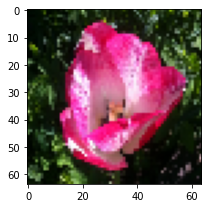

In [4]:
img1=get_resize_img1(file_path,file_name,img_size=64)

In [5]:
def get_resize_img2(file_path,file_name,img_size=64):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    img=cv2.imread(file_name)
    img=cv2.resize(img,(img_size,img_size))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    print('mean: %f'%img.mean())
    img=img.reshape(1,img_size,img_size,3)
    fig=pl.figure(figsize=(3,3))
    pl.imshow(img[0]/255); pl.tight_layout(); pl.show()
    return tf.cast(img,tf.float32)

mean: 77.635254


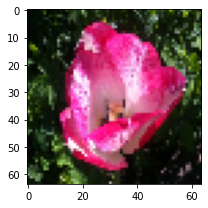

In [6]:
img2=get_resize_img2(file_path,file_name,img_size=64)

In [7]:
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
def highpass_xy(img):
    x_var=img[:,:,1:,:]-img[:,:,:-1,:]
    y_var=img[:,1:,:,:]-img[:,:-1,:,:]
    return x_var,y_var
def clip01(img):
    return tf.clip_by_value(
        img,clip_value_min=0.,clip_value_max=1.)
def load_img(file_name,max_dim=512):
    img=tf.io.read_file(file_name)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    scale=max_dim/max(shape)
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]

## ✒️  Image Manipulations

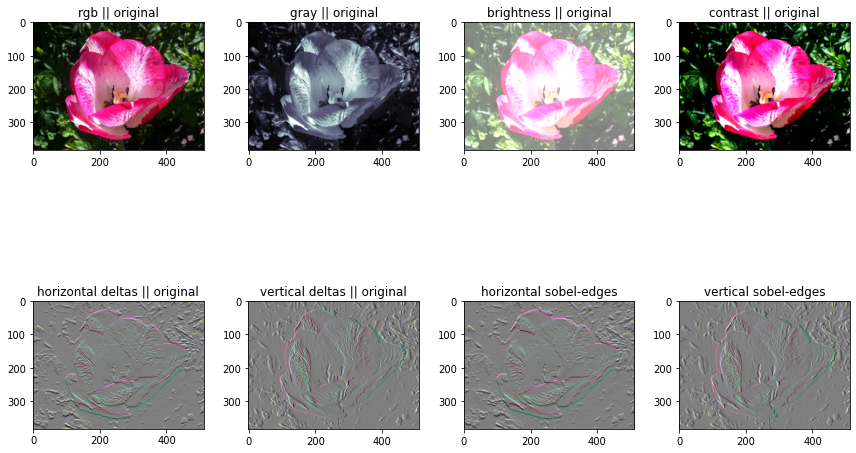

In [8]:
get_file(file_path,file_name)
original_img=load_img(file_name)
contrast=1.5; brightness=.5
gray_img=np.dot(original_img[...,:3],[.299,.587,.114])
contrast_img=tf.image.adjust_contrast(original_img,contrast)
brightness_img=tf.image.adjust_brightness(original_img,brightness)
converted_img=tf.image.grayscale_to_rgb(tf.constant(
    gray_img.reshape(list(gray_img.shape[1:])+[1])))
x_deltas,y_deltas=highpass_xy(original_img)
sobel=tf.image.sobel_edges(original_img)
pl.figure(figsize=(12,9))
pl.subplot(2,4,1)
pl.imshow(tf.squeeze(clip01(original_img)))
pl.title('rgb || original')
pl.subplot(2,4,2)
pl.imshow(tf.squeeze(clip01(gray_img)),cmap='bone')
pl.title('gray || original')
pl.subplot(2,4,3)
pl.imshow(tf.squeeze(clip01(brightness_img)))
pl.title('brightness || original')
pl.subplot(2,4,4)
pl.imshow(tf.squeeze(clip01(contrast_img)))
pl.title('contrast || original')
pl.subplot(2,4,5)
pl.imshow(tf.squeeze(clip01(2*y_deltas+.5)))
pl.title('horizontal deltas || original')
pl.subplot(2,4,6)
pl.imshow(tf.squeeze(clip01(2*x_deltas+.5)))
pl.title('vertical deltas || original')
sobel=tf.image.sobel_edges(original_img)
pl.subplot(2,4,7)
pl.imshow(tf.squeeze(clip01(sobel[...,0]/4+.5)))
pl.title('horizontal sobel-edges')
pl.subplot(2,4,8)
pl.imshow(tf.squeeze(clip01(sobel[...,1]/4+.5)))
pl.title('vertical sobel-edges');
pl.tight_layout(); pl.show()

In [9]:
def get_img(file_name,flag,file_path=file_path):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    img=cv2.imread(file_name)
    return cv2.cvtColor(img,flag) 

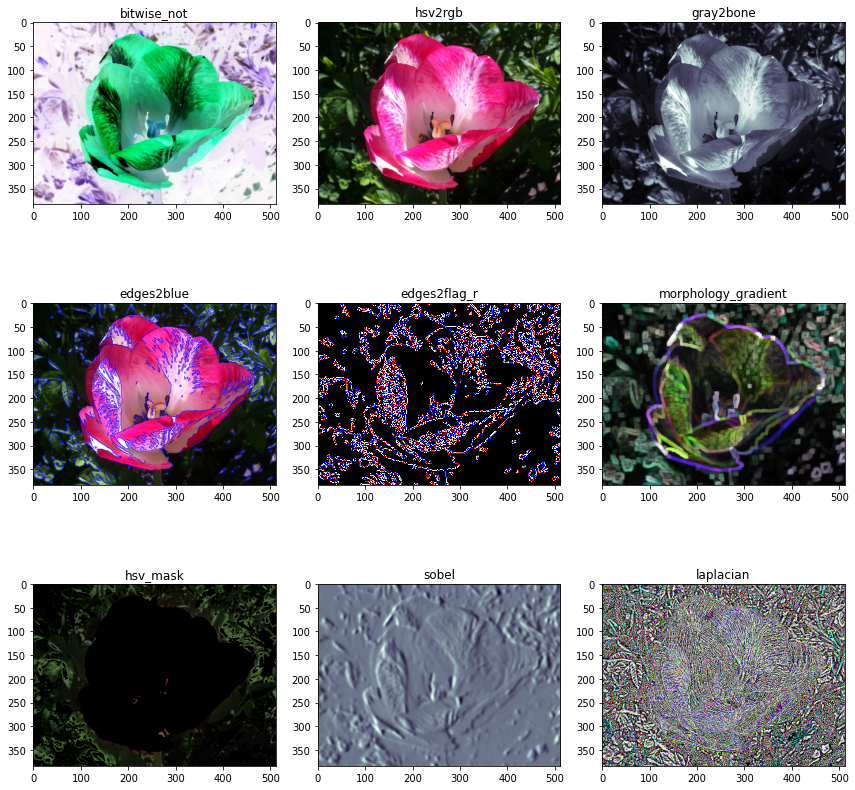

In [10]:
rgb=get_img(file_name,flag=cv2.COLOR_BGR2RGB)
edge_img=rgb.copy()
hsv=cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
gray=cv2.cvtColor(bgr,cv2.COLOR_BGR2GRAY)
edge=cv2.Canny(np.uint8(gray),100,200)
edge_img[edge!=0]=(0,0,255)
[lr,lg,lb]=[0,0,0]; [ur,ug,ub]=[30,130,30]
lower_hsv=cv2.cvtColor(np.uint8([[[lr,lg,lb]]]),cv2.COLOR_BGR2HSV)[0][0]
upper_hsv=cv2.cvtColor(np.uint8([[[ur,ug,ub]]]),cv2.COLOR_BGR2HSV)[0][0]
hsv_str=str([lower_hsv,upper_hsv])
mask=cv2.inRange(hsv,np.array(lower_hsv),np.array(upper_hsv))
result=cv2.bitwise_and(bgr,bgr,mask=mask)
kernel=np.ones((7,7),np.uint8)
gradient=cv2.morphologyEx(bgr,cv2.MORPH_GRADIENT,kernel)
sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=27)
laplacian=np.uint8(cv2.Laplacian(np.uint8(bgr),cv2.CV_64F))
pl.figure(figsize=(12,12))
pl.subplot(331),pl.imshow(cv2.bitwise_not(rgb)/255)
pl.title('bitwise_not')
pl.subplot(332),\
pl.imshow(cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)/255)
pl.title('hsv2rgb')
pl.subplot(333),pl.imshow(gray,cmap='bone'),pl.title('gray2bone')
pl.subplot(334),pl.imshow(edge_img/255),pl.title('edges2blue')
pl.subplot(335),pl.imshow(edge,cmap='flag_r'),pl.title('edges2flag_r')
pl.subplot(336),pl.imshow(gradient/255)
pl.title('morphology_gradient')
pl.subplot(337),pl.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB)/255)
pl.title('hsv_mask')
pl.subplot(338),pl.imshow(sobel,cmap='bone'),pl.title('sobel')
pl.subplot(339),pl.imshow(laplacian,cmap='bone'),pl.title('laplacian')
pl.tight_layout(); pl.show()